In [1]:
from scipy.optimize import minimize
from scipy import stats
import numpy as np, pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Let's plot some of these examples:
np.random.seed(2021)

b0 = 1
b1 = .04
b2 = 1.5
b3 = .0125
b4 = 2.67

x1 = np.random.normal(10, 20,
                      size=(100,1))

noise = np.random.randn(100).reshape((100,1))

y = {'Linear': (b0 - b1*x1).reshape((100,1)),
     'Quadratic': (b0 + b1*x1 - b2*(x1**2)).reshape((100,1)),
     'Sigmoid': ( ( 1 / (1 + np.exp(b2 + b4*x1)) )).reshape((100,1)),
     'Exponential': (80*np.exp(-b1*x1)).reshape((100,1)),
     'Hyperbolic': ((80/(1 + b3*x1))).reshape((100,1))}

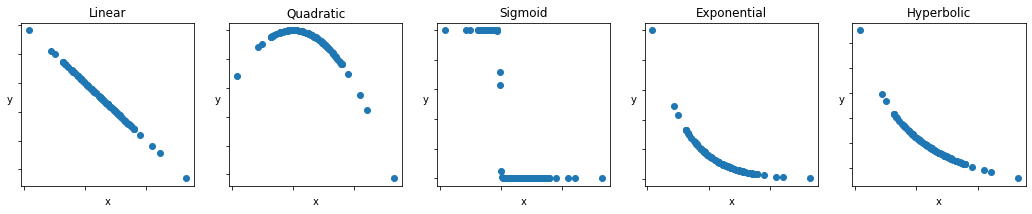

In [3]:
fig, axes = plt.subplots(ncols=5, figsize=(18, 3))

for (key, values), ax in zip(y.items(), axes):
    
    # True data
    ax.scatter(x1, values)  # our data scatter plot

    ax.set(title= fr'{key}')
    
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_xlabel('x')
    ax.set_ylabel('y', rotation=0)

plt.show()

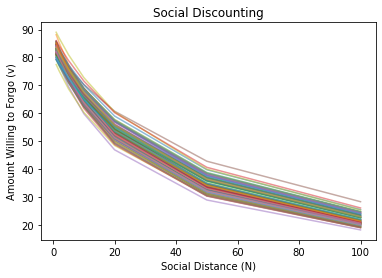

In [4]:
np.random.seed(2021)

v0 = np.random.normal(85, 2,
                      size=(100,))

k = np.random.normal(.03, .005,
                      size=(100,))

N = np.array([1,2,5,10,20,50,100])

v = []
for i in range(100):
    v.append((v0[i] / (1 + k[i]*N)) + noise[i]) 
    plt.plot(N, v[i], alpha=.5)

plt.title('Social Discounting')
plt.ylabel('Amount Willing to Forgo (v)')
plt.xlabel('Social Distance (N)')
plt.show()

In [5]:
def mse_linear(params, N, v):
    
    v0, k = params
    v_fit = v0 + k*N
    
    mse = np.mean((v - v_fit)**2)
    
    return mse   

In [6]:
def mse_exponential(params, N, v):
    
    v0, k = params
    v_fit = v0*np.exp(-k*N)
    
    mse = np.mean((v - v_fit)**2)
    
    return mse    

In [7]:
def mse_hyperbolic(params, N, v):
    
    v0, k = params
    v_fit = (v0 / (1 + k*N))
    
    mse = np.mean((v - v_fit)**2)
    
    return mse

In [8]:
# initialize dictionary to store results
results = {"lin": [],
           "exp": [],
           "hyp": []}

# minimize MSE for linear function using scipy.optimize.minimize
results["lin"] = minimize(mse_linear, # objective function
                          (85, -.3), # estimated starting points
                          args=(N, v), # arguments
                          bounds=((50,100),(-1,1)),
                          tol=1e-3)

# minimize MSE for hyperbolic function using scipy.optimize.minimize
results["exp"] = minimize(mse_exponential, # objective function
                          (92, .6), # estimated starting points
                          args=(N, v), # arguments
                          bounds=((50,100),(0,1)),
                          tol=1e-3)

# minimize MSE for hyperbolic function using scipy.optimize.minimize
results["hyp"] = minimize(mse_hyperbolic, # objective function
                          (70, .05), # estimated starting points
                          args=(N, v), # arguments
                          bounds=((50,100),(0,1)),
                          tol=1e-3)

print(f'Linear: v0 = {results["lin"].x[0]:.2f}, k = {results["lin"].x[1]:.3f}, MSE = {results["lin"].fun:.2f}')
print(f'Exponential: v0 = {results["exp"].x[0]:.2f}, k = {results["exp"].x[1]:.3f}, MSE = {results["exp"].fun:.2f}')
print(f'Hyperbolic: v0 = {results["hyp"].x[0]:.2f}, k = {results["hyp"].x[1]:.3f}, MSE = {results["hyp"].fun:.2f}')

Linear: v0 = 75.27, k = -0.609, MSE = 59.00
Exponential: v0 = 80.75, k = 0.016, MSE = 16.90
Hyperbolic: v0 = 85.20, k = 0.030, MSE = 4.86


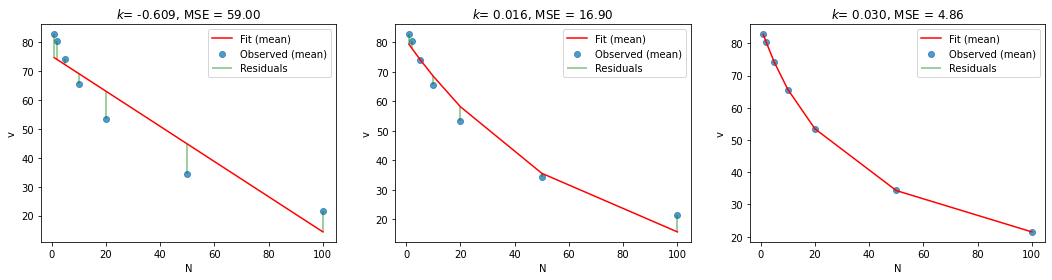

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
for (model, fits), ax in zip(results.items(), axes):

    # True data
    v_mean = np.mean(v, axis=0)
    ax.scatter(N, v_mean, 
               alpha = .75,
               label = 'Observed (mean)')  # our data scatter plot
    
    v0, k = fits.x
    mse_val = fits.fun

    # Compute and plot predictions
    if model == "lin":
        v_hat = v0 + k * N
    elif model == "exp":
        v_hat = v0*np.exp(-k*N)
    elif model == "hyp":
        v_hat = v0 / (1 + k*N)
        
    ax.plot(N, v_hat, color='r', label='Fit (mean)')  # our estimated model
    
    # plot residuals
    vmin = np.minimum(v_mean, v_hat)
    vmax = np.maximum(v_mean, v_hat)

    ax.vlines(N, vmin, vmax, 'g', alpha=0.5, label='Residuals')

    ax.set(
      title= fr'$k$= {k:.3f}, MSE = {mse_val:.2f}',
      xlabel='N',
      ylabel='v')
    
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

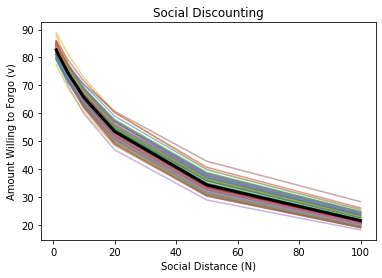

In [10]:
# plot all individual subjects
for v_subj in v:
    plt.plot(N, v_subj, alpha=.5)

# plot mean model fit
v_hat = results["hyp"].x[0] / (1 + results["hyp"].x[1]*N)        
plt.plot(N, v_hat, 
         color='black', 
         linewidth=3, 
         label='Fit (mean)')  # our estimated model

plt.title('Social Discounting')
plt.ylabel('Amount Willing to Forgo (v)')
plt.xlabel('Social Distance (N)')
plt.show()

In [11]:
# See small differences between fitted and observed values
print(f'{v_hat} -- Fits')
print(f'{v_mean} -- Observed')

[82.74082911 80.42375605 74.19083835 65.70397111 53.47069094 34.30767545
 21.47846286] -- Fits
[82.80278641 80.45272539 74.15481504 65.62721642 53.40723605 34.34937097
 21.58152985] -- Observed


In [12]:
# initialize a DataFrame, with columns corresponding to params ['v0', k] and rows corresponding to subjects
res_df = pd.DataFrame(columns=['v0', 'k'])

for subj_id, subj_v in enumerate(v):
    
    # minimize MSE for hyperbolic function using scipy.optimize.minimize
    fit = minimize(mse_hyperbolic, # objective function
                   (85, .05), # estimated starting points
                   args=(N, subj_v), # arguments
                   bounds=((50,100),(0,1)),
                   tol=1e-3)
        
    res_df.loc[subj_id, 'v0'] = fit.x[0]
    res_df.loc[subj_id, 'k'] = fit.x[1]
    res_df.loc[subj_id, 'MSE'] = fit.fun
    
    print(f'subject {subj_id}: v0 = {fit.x[0]:.2f}, k = {fit.x[1]:.3f}, MSE = {fit.fun:.2f}')

subject 0: v0 = 87.34, k = 0.027, MSE = 0.01
subject 1: v0 = 86.74, k = 0.032, MSE = 0.00
subject 2: v0 = 85.18, k = 0.035, MSE = 0.04
subject 3: v0 = 83.00, k = 0.028, MSE = 0.00
subject 4: v0 = 86.56, k = 0.032, MSE = 0.01
subject 5: v0 = 84.06, k = 0.032, MSE = 0.01
subject 6: v0 = 86.89, k = 0.028, MSE = 0.00
subject 7: v0 = 86.93, k = 0.033, MSE = 0.01
subject 8: v0 = 85.61, k = 0.032, MSE = 0.01
subject 9: v0 = 85.08, k = 0.026, MSE = 0.01
subject 10: v0 = 84.65, k = 0.027, MSE = 0.01
subject 11: v0 = 83.70, k = 0.032, MSE = 0.00
subject 12: v0 = 85.19, k = 0.027, MSE = 0.01
subject 13: v0 = 83.93, k = 0.024, MSE = 0.03
subject 14: v0 = 82.90, k = 0.038, MSE = 0.14
subject 15: v0 = 87.24, k = 0.030, MSE = 0.00
subject 16: v0 = 82.73, k = 0.033, MSE = 0.01
subject 17: v0 = 83.61, k = 0.025, MSE = 0.02
subject 18: v0 = 82.53, k = 0.031, MSE = 0.00
subject 19: v0 = 85.92, k = 0.031, MSE = 0.00
subject 20: v0 = 83.91, k = 0.032, MSE = 0.00
subject 21: v0 = 91.07, k = 0.035, MSE = 0.0


subject 33: v0 = 84.37, k = 0.031, MSE = 0.00
subject 34: v0 = 85.88, k = 0.032, MSE = 0.00
subject 35: v0 = 85.53, k = 0.032, MSE = 0.01
subject 36: v0 = 83.40, k = 0.032, MSE = 0.01
subject 37: v0 = 86.35, k = 0.037, MSE = 0.11
subject 38: v0 = 79.91, k = 0.032, MSE = 0.01
subject 39: v0 = 85.62, k = 0.029, MSE = 0.00
subject 40: v0 = 85.60, k = 0.031, MSE = 0.00
subject 41: v0 = 86.42, k = 0.032, MSE = 0.01
subject 42: v0 = 84.90, k = 0.027, MSE = 0.01
subject 43: v0 = 87.15, k = 0.032, MSE = 0.00
subject 44: v0 = 81.64, k = 0.027, MSE = 0.01
subject 45: v0 = 87.58, k = 0.031, MSE = 0.00
subject 46: v0 = 82.66, k = 0.024, MSE = 0.02
subject 47: v0 = 88.35, k = 0.037, MSE = 0.11
subject 48: v0 = 83.87, k = 0.034, MSE = 0.03
subject 49: v0 = 83.54, k = 0.029, MSE = 0.00
subject 50: v0 = 87.04, k = 0.032, MSE = 0.00
subject 51: v0 = 82.67, k = 0.031, MSE = 0.00
subject 52: v0 = 83.27, k = 0.025, MSE = 0.02
subject 53: v0 = 84.08, k = 0.036, MSE = 0.07
subject 54: v0 = 87.91, k = 0.035


subject 56: v0 = 83.40, k = 0.023, MSE = 0.03
subject 57: v0 = 84.98, k = 0.036, MSE = 0.08
subject 58: v0 = 88.32, k = 0.034, MSE = 0.03
subject 59: v0 = 82.08, k = 0.025, MSE = 0.02
subject 60: v0 = 86.55, k = 0.024, MSE = 0.03
subject 61: v0 = 85.16, k = 0.032, MSE = 0.01
subject 62: v0 = 85.18, k = 0.024, MSE = 0.02
subject 63: v0 = 86.37, k = 0.030, MSE = 0.00
subject 64: v0 = 85.07, k = 0.029, MSE = 0.00
subject 65: v0 = 84.85, k = 0.035, MSE = 0.06
subject 66: v0 = 84.30, k = 0.033, MSE = 0.01
subject 67: v0 = 88.06, k = 0.036, MSE = 0.08
subject 68: v0 = 87.70, k = 0.033, MSE = 0.02
subject 69: v0 = 84.96, k = 0.033, MSE = 0.02
subject 70: v0 = 86.41, k = 0.026, MSE = 0.01
subject 71: v0 = 85.45, k = 0.024, MSE = 0.02
subject 72: v0 = 81.49, k = 0.030, MSE = 0.00
subject 73: v0 = 83.34, k = 0.030, MSE = 0.00
subject 74: v0 = 82.40, k = 0.031, MSE = 0.00
subject 75: v0 = 83.74, k = 0.032, MSE = 0.00
subject 76: v0 = 86.06, k = 0.027, MSE = 0.01
subject 77: v0 = 88.30, k = 0.029


subject 93: v0 = 88.16, k = 0.023, MSE = 0.03
subject 94: v0 = 81.63, k = 0.023, MSE = 0.03
subject 95: v0 = 83.84, k = 0.026, MSE = 0.02
subject 96: v0 = 84.69, k = 0.033, MSE = 0.01
subject 97: v0 = 85.31, k = 0.027, MSE = 0.01
subject 98: v0 = 85.96, k = 0.027, MSE = 0.01
subject 99: v0 = 82.42, k = 0.027, MSE = 0.01


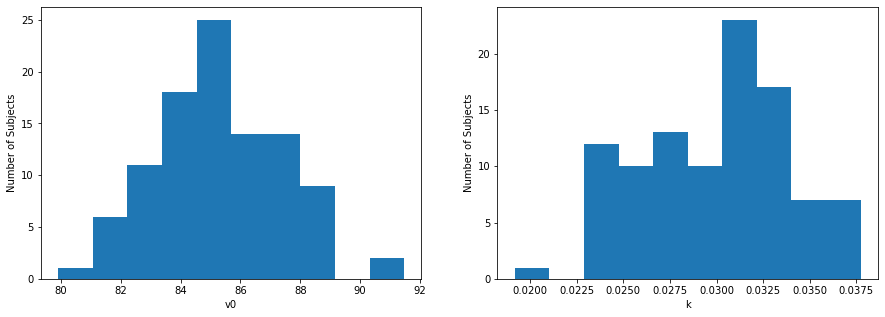

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

axes[0].hist(res_df['v0'], bins=10)
axes[0].set(ylabel="Number of Subjects", xlabel="v0")

axes[1].hist(res_df['k'], bins=10)
axes[1].set(ylabel="Number of Subjects", xlabel="k")

plt.show()

In [14]:
def calculate_bic(sample_size, mse, num_params):
    bic = -2 * np.log(mse) + num_params * np.log(sample_size)
    return bic

In [15]:
# calculate the Bayesian Information Criterion (bic)
for key, output in results.items():
    bic = calculate_bic(len(v_mean), output.fun, 2)
    print(f'{key} (BIC): {bic:.3f}')

lin (BIC): -4.263
exp (BIC): -1.763
hyp (BIC): 0.730


In [16]:
# First let's load in the data

# here, we are just going to download data from the web (no need to edit these lines, but try to figure out what they are doing)
url = 'https://raw.githubusercontent.com/shawnrhoads/gu-psyc-347/master/docs/static/data/Vekaria-et-al-2017_data.csv'
df = pd.read_csv(url, index_col='subject')
print(df.head())

          1   2   5  10  20  50  100
subject                             
102      85  85  85  85  85  65   85
106      85  85  -5   5   5   5    5
107      85  85  85  85  85   5    5
113      85  55  65  55  25  15    5
114      65  55  45  55  45  15   15


In [17]:
vekaria_data = df.values

print(vekaria_data.shape)

(25, 7)


In [18]:
fit1 = minimize(mse_hyperbolic, # objective function
               (85, .05), # estimated starting points
               args=(N, df.iloc[:,0:7].values), # arguments
               bounds=((0,80),(0,1)),
               tol=1e-3)

# minimize MSE for exponential function using scipy.optimize.minimize
fit2 = minimize(mse_exponential, # objective function
               (85, .05), # estimated starting points
               args=(N, df.iloc[:,0:7].values), # arguments
               bounds=((0,80),(0,1)),
               tol=1e-3)

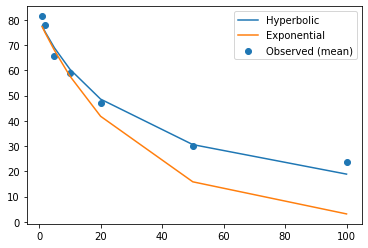

In [19]:
# fig, axes = plt.subplots()
fig = plt.figure()    

plt.scatter(N, np.mean(df.iloc[:,0:7].values, axis=0), label='Observed (mean)')
plt.plot(N, fit1.x[0] / (1 + fit1.x[1]*N), label='Hyperbolic')
plt.plot(N, fit2.x[0] * np.exp(-fit1.x[1]*N), label='Exponential')
plt.legend()

plt.show()

In [20]:
# calculate the Bayesian Information Criterion (bic)
for label, output in zip(['hyperbolic', 'exponential'], [fit1, fit2]):
    bic = calculate_bic(len(vekaria_data), output.fun, 2)
    print(f'{label} (BIC): {bic:.3f}')

hyperbolic (BIC): -6.567
exponential (BIC): -6.668


In [21]:
# initialize a DataFrame, with columns corresponding to params ['v0', k] and rows corresponding to subjects
res_vekaria = pd.DataFrame(columns=['v0', 'k'])

for subj_id, subj_v in zip(df.index, vekaria_data):
    
    # minimize MSE for hyperbolic function using scipy.optimize.minimize
    fit = minimize(mse_hyperbolic, # objective function
                   (85, .05), # estimated starting points
                   args=(N, subj_v), # arguments
                   bounds=((0,80),(0,1)),
                   tol=1e-3)
        
    res_vekaria.loc[subj_id, 'v0'] = fit.x[0]
    res_vekaria.loc[subj_id, 'k'] = fit.x[1]
    res_vekaria.loc[subj_id, 'MSE'] = fit.fun
    
    print(f'subject {subj_id}: v0 = {fit.x[0]:.2f}, k = {fit.x[1]:.3f}, MSE = {fit.fun:.2f}')

subject 102: v0 = 80.00, k = 0.000, MSE = 53.53
subject 106: v0 = 80.00, k = 0.301, MSE = 488.09
subject 107: v0 = 80.00, k = 0.024, MSE = 430.10
subject 113: v0 = 79.88, k = 0.074, MSE = 75.61
subject 114: v0 = 62.64, k = 0.033, MSE = 42.86
subject 116: v0 = 80.00, k = 0.000, MSE = 25.00
subject 119: v0 = 80.00, k = 0.021, MSE = 370.64
subject 120: v0 = 79.94, k = 0.087, MSE = 224.61
subject 121: v0 = 80.00, k = 0.000, MSE = 25.00
subject 122: v0 = 80.00, k = 0.003, MSE = 62.99
subject 123: v0 = 79.62, k = 0.110, MSE = 358.13
subject 124: v0 = 79.97, k = 0.062, MSE = 55.33
subject 125: v0 = 80.00, k = 0.019, MSE = 294.43
subject 126: v0 = 80.00, k = 0.006, MSE = 820.72
subject 127: v0 = 80.00, k = 0.030, MSE = 138.29
subject 128: v0 = 80.00, k = 0.000, MSE = 25.00
subject 132: v0 = 80.00, k = 0.024, MSE = 196.97
subject 135: v0 = 80.00, k = 0.056, MSE = 503.05
subject 136: v0 = 79.98, k = 0.089, MSE = 271.09
subject 137: v0 = 80.00, k = 0.021, MSE = 351.20
subject 138: v0 = 80.00, k =

In [22]:
for subj_id, subj_v in zip(df.index, vekaria_data):
    if all(x==subj_v[0] for x in subj_v):
        print(f'no variation for subject #{subj_id}, {subj_v}')

no variation for subject #116, [85 85 85 85 85 85 85]
no variation for subject #121, [85 85 85 85 85 85 85]
no variation for subject #128, [85 85 85 85 85 85 85]


In [23]:
# initialize a DataFrame, with columns corresponding to params ['v0', k] and rows corresponding to subjects
hyp_vekaria = pd.DataFrame(columns=['v0', 'k'])

for subj_id, subj_v in zip(df.index, vekaria_data):
    
    if all(x==subj_v[0] for x in subj_v):
        if np.sum(subj_v)>=595:
            
            hyp_vekaria.loc[subj_id, 'v0'] = 80 # 
            hyp_vekaria.loc[subj_id, 'k'] = 0
            hyp_vekaria.loc[subj_id, 'MSE'] = np.nan
            
            print(f'assigning k=0 for subject #{subj_id}, {subj_v}')
    else:
    
        # minimize MSE for hyperbolic function using scipy.optimize.minimize
        fit = minimize(mse_hyperbolic, # objective function
                       (85, .05), # estimated starting points
                       args=(N, subj_v), # arguments
                       bounds=((0,80),(0,1)),
                       tol=1e-3)

        hyp_vekaria.loc[subj_id, 'v0'] = fit.x[0]
        hyp_vekaria.loc[subj_id, 'k'] = fit.x[1]
        hyp_vekaria.loc[subj_id, 'MSE'] = fit.fun

res_vekaria = pd.concat([df, hyp_vekaria], axis=1)

assigning k=0 for subject #116, [85 85 85 85 85 85 85]
assigning k=0 for subject #121, [85 85 85 85 85 85 85]
assigning k=0 for subject #128, [85 85 85 85 85 85 85]


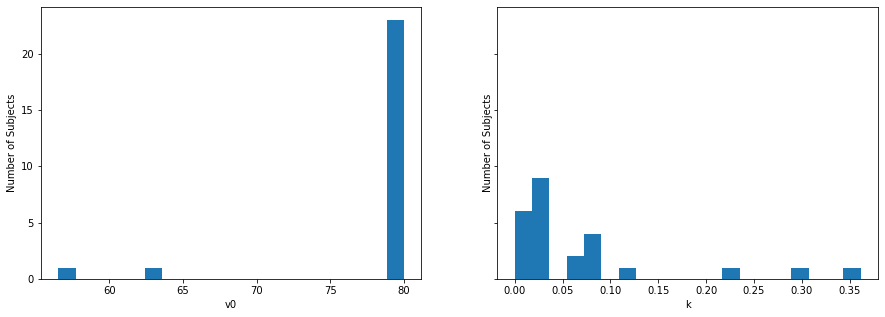

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)

axes[0].hist(res_vekaria['v0'], bins=20)
axes[0].set(ylabel="Number of Subjects", xlabel="v0")

axes[1].hist(res_vekaria['k'], bins=20)
axes[1].set(ylabel="Number of Subjects", xlabel="k")

plt.show()